# Imports
sklearn, tensorflow, matplotlib, seaborn, numpy and pandas needs to be installed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import re
import shutil
import gc
import requests
import zipfile
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError

# Phase 0 : Setup and Init
## Download
Here we check if the datas are here and download them if not

In [2]:
PROJECT_ROOT = "."

ZIP_FILE_PATH = os.path.join(PROJECT_ROOT, "KuaiRec.zip")


EXTRACTION_PARENT_DIR = os.path.join(PROJECT_ROOT, "data_final_project")


DOWNLOAD_URL = "https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470"


KEY_DATA_FILE_IN_DATA_SUBDIR = "small_matrix.csv" 



def find_the_path(base_path):
    glob_pattern = os.path.join(base_path, "KuaiRec*")
    potential_kuairec_folders = glob.glob(glob_pattern)
    
    for folder_path in potential_kuairec_folders:
        if os.path.isdir(folder_path):
            data_subdir_path = os.path.join(folder_path, "data")
            if os.path.isdir(data_subdir_path):
                if os.path.exists(os.path.join(data_subdir_path, KEY_DATA_FILE_IN_DATA_SUBDIR)):
                    return data_subdir_path
    return None

RAW_KUAIREC_DATA_PATH = find_the_path(EXTRACTION_PARENT_DIR)


if RAW_KUAIREC_DATA_PATH:
    print("Dataset already downloaded")
else:
    print("Dataset not found, downloading it...")
    
    os.makedirs(EXTRACTION_PARENT_DIR, exist_ok=True)

    if not os.path.exists(ZIP_FILE_PATH):
        try:
            session = requests.Session()
            response = session.get(DOWNLOAD_URL, stream=True, timeout=300)
            response.raise_for_status()

            with open(ZIP_FILE_PATH, 'wb') as f:
                chunk_size = 8192
                downloaded_size = 0
                total_size = int(response.headers.get('content-length', 0))

                for chunk in response.iter_content(chunk_size=chunk_size):
                    f.write(chunk)
                    downloaded_size += len(chunk)
                    if total_size > 0:
                        progress = (downloaded_size / total_size) * 100

            print("Dataset succesfully downloaded, extracting it...")
        except:
            if os.path.exists(ZIP_FILE_PATH):
                os.remove(ZIP_FILE_PATH)
            ZIP_FILE_PATH = None

            print("Download failed, check internet connection maybe")


    if ZIP_FILE_PATH and os.path.exists(ZIP_FILE_PATH):
        with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACTION_PARENT_DIR)

        RAW_KUAIREC_DATA_PATH = find_the_path(EXTRACTION_PARENT_DIR)
            
    elif not ZIP_FILE_PATH: 
         print("Download has failed, retry and check internet connectin")


if RAW_KUAIREC_DATA_PATH:
    print("Success !")
else:
    print("Error")

Dataset not found, downloading it...
Dataset succesfully downloaded, extracting it...
Success !


## Here we set up the paths

In [3]:
PROCESSED_DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUTPUTS_DIR = os.path.join(PROJECT_ROOT, "outputs")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

INTERACTIONS_TRAIN_FILENAME_RAW = "big_matrix.csv"
INTERACTIONS_TEST_FILENAME_RAW = "small_matrix.csv"
VIDEO_METADATA_FILENAME_RAW = "kuairec_caption_category.csv"
USER_FEATURES_FILENAME_RAW = "user_features.csv"
ITEM_CATEGORIES_FILENAME_RAW = "item_categories.csv"
ITEM_DAILY_FEATURES_FILENAME_RAW = "item_daily_features.csv"

PROJECT_INTERACTIONS_TRAIN_FILE = "interactions_train_sample.csv"
PROJECT_INTERACTIONS_TEST_FILE = "interactions_test.csv"
PROJECT_VIDEO_METADATA_FILE = "video_metadata.csv"
PROJECT_USER_FEATURES_FILE = "user_features.csv"
PROJECT_ITEM_CATEGORIES_FILE = "item_categories.csv"
PROJECT_ITEM_DAILY_FEATURES_FILE = "item_daily_features.csv"
PROJECT_SAMPLE_SUBMISSION_FILE = "sample_submission.csv"

PATH_PROJECT_INTERACTIONS_TRAIN = os.path.join(PROCESSED_DATA_DIR, PROJECT_INTERACTIONS_TRAIN_FILE)
PATH_PROJECT_INTERACTIONS_TEST = os.path.join(PROCESSED_DATA_DIR, PROJECT_INTERACTIONS_TEST_FILE)
PATH_PROJECT_VIDEO_METADATA = os.path.join(PROCESSED_DATA_DIR, PROJECT_VIDEO_METADATA_FILE)
PATH_PROJECT_USER_FEATURES = os.path.join(PROCESSED_DATA_DIR, PROJECT_USER_FEATURES_FILE)
PATH_PROJECT_ITEM_CATEGORIES = os.path.join(PROCESSED_DATA_DIR, PROJECT_ITEM_CATEGORIES_FILE)
PATH_PROJECT_ITEM_DAILY_FEATURES = os.path.join(PROCESSED_DATA_DIR, PROJECT_ITEM_DAILY_FEATURES_FILE)

PATH_SUBMISSION_OUTPUT = os.path.join(OUTPUTS_DIR, "submission.csv")
NROWS_SAMPLE_BIG_MATRIX = 5_000_000

plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["figure.facecolor"] = "white"
sns.set_theme(style="whitegrid", palette="muted")

print("Paths setted up")

Paths setted up


## Utils and eval function

In [4]:
def calculate_sparsity(df, user_col='user_id', item_col='video_id'):
    if df.empty: 
        return 0,0,0,0
    n_users = df[user_col].nunique()
    n_items = df[item_col].nunique()
    n_interactions = len(df)
    if (n_users * n_items) > 0:
        sparsity = 1.0 - (n_interactions / (n_users * n_items))
    else:
        sparsity = 1.0

    return sparsity, n_users, n_items, n_interactions

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def precision_at_k(user_ranked_list_with_true_relevance, k, relevance_threshold):
    top_k_items = user_ranked_list_with_true_relevance[:k]
    if not top_k_items:
        return 0.0

    relevant_in_top_k = 0
    for _, _, true_relevance in top_k_items:
        if true_relevance >= relevance_threshold:
            relevant_in_top_k += 1

    return relevant_in_top_k / k

def recall_at_k(user_ranked_list_with_true_relevance, all_relevant_items_for_user_set, k):
    if not all_relevant_items_for_user_set:
        top_k = user_ranked_list_with_true_relevance[:k]
        if not top_k:
            return 1.0
        else:
            return 0.0

    top_k_item_ids = set()
    for item_id, _, _ in user_ranked_list_with_true_relevance[:k]:
        top_k_item_ids.add(item_id)

    relevant_and_recommended = 0
    for item_id in top_k_item_ids:
        if item_id in all_relevant_items_for_user_set:
            relevant_and_recommended += 1

    total_relevant_items = len(all_relevant_items_for_user_set)
    recall = relevant_and_recommended / total_relevant_items
    return recall


def dcg_at_k(user_ranked_list_with_true_relevance, k):
    dcg = 0.0
    for i, (_, _, true_relevance) in enumerate(user_ranked_list_with_true_relevance[:k]):
        dcg += true_relevance / np.log2(i + 2) 
    return dcg

def ndcg_at_k(user_ranked_list_with_true_relevance, k):
    actual_dcg = dcg_at_k(user_ranked_list_with_true_relevance, k)
    ideal_ranked_list = sorted(user_ranked_list_with_true_relevance, key=lambda x: x[2], reverse=True)
    ideal_dcg = dcg_at_k(ideal_ranked_list, k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

print("eval and utils functions defined.")

eval and utils functions defined.


# Phase 1 : Data Loading and Preparation
## Copying files
Here we copy usefull files from "data_final/project/KuaiRec 2.0/data\" into "data"

In [5]:
src_big_matrix = os.path.join(RAW_KUAIREC_DATA_PATH, INTERACTIONS_TRAIN_FILENAME_RAW)
if not os.path.exists(PATH_PROJECT_INTERACTIONS_TRAIN):
    if os.path.exists(src_big_matrix):
        try:
            chunk_iter = pd.read_csv(src_big_matrix, chunksize=100000, nrows=NROWS_SAMPLE_BIG_MATRIX)
            df_sample = pd.concat(chunk_iter)
            df_sample.to_csv(PATH_PROJECT_INTERACTIONS_TRAIN, index=False)
            del df_sample
            gc.collect()
        except Exception as e:
            print(f"Error when trying to process {src_big_matrix}. Datas or datas path might be incorret")
    else:
        print(f"File {src_big_matrix} not found. It needs to be in \"data_final/project/KuaiRec 2.0/data\" relative to this file")


src_small_matrix = os.path.join(RAW_KUAIREC_DATA_PATH, INTERACTIONS_TEST_FILENAME_RAW)
if not os.path.exists(PATH_PROJECT_INTERACTIONS_TEST):
    if os.path.exists(src_small_matrix):
        shutil.copy(src_small_matrix, PATH_PROJECT_INTERACTIONS_TEST)
    else:
        print(f"File {src_small_matrix} not found. It needs to be in \"data_final/project/KuaiRec 2.0/data\" relative to this file")


src_video_meta = os.path.join(RAW_KUAIREC_DATA_PATH, VIDEO_METADATA_FILENAME_RAW)
if not os.path.exists(PATH_PROJECT_VIDEO_METADATA):
    if os.path.exists(src_video_meta):
        shutil.copy(src_video_meta, PATH_PROJECT_VIDEO_METADATA)
    else:
        print(f"File {src_video_meta} not found. It needs to be in \"data_final/project/KuaiRec 2.0/data\" relative to this file")


src_user_features = os.path.join(RAW_KUAIREC_DATA_PATH, USER_FEATURES_FILENAME_RAW)
if not os.path.exists(PATH_PROJECT_USER_FEATURES):
    if os.path.exists(src_user_features):
        shutil.copy(src_user_features, PATH_PROJECT_USER_FEATURES)
    else:
        print(f"File {src_user_features} not found. It needs to be in \"data_final/project/KuaiRec 2.0/data\" relative to this file")


src_item_cat = os.path.join(RAW_KUAIREC_DATA_PATH, ITEM_CATEGORIES_FILENAME_RAW)
if not os.path.exists(PATH_PROJECT_ITEM_CATEGORIES):
    if os.path.exists(src_item_cat):
        shutil.copy(src_item_cat, PATH_PROJECT_ITEM_CATEGORIES)
    else:
        print(f"File {src_item_cat} not found. It needs to be in \"data_final/project/KuaiRec 2.0/data\" relative to this file")


print("Copying done")


Copying done


## Loading
Here we load the csv data files into pandas dataframes

In [6]:
interactions_df = pd.read_csv(PATH_PROJECT_INTERACTIONS_TRAIN)
interactions_df_test = pd.read_csv(PATH_PROJECT_INTERACTIONS_TEST)
video_meta_df = pd.read_csv(PATH_PROJECT_VIDEO_METADATA, engine='python')
user_features_df = pd.read_csv(PATH_PROJECT_USER_FEATURES)

print("Data loading into df done")

Data loading into df done


# Phase 2 : Data Analysis
## Informations display
We are going to display informations and graphs of the differents dataframes we just got

# Informations on interactions data :
Shape: (5000000, 8)
Head:
    user_id  video_id  play_duration  video_duration                     time  \
0        0      3649          13838           10867  2020-07-05 00:08:23.438   
1        0      9598          13665           10984  2020-07-05 00:13:41.297   
2        0      5262            851            7908  2020-07-05 00:16:06.687   
3        0      1963            862            9590  2020-07-05 00:20:26.792   
4        0      8234            858           11000  2020-07-05 00:43:05.128   

       date     timestamp  watch_ratio  
0  20200705  1.593879e+09     1.273397  
1  20200705  1.593879e+09     1.244082  
2  20200705  1.593879e+09     0.107613  
3  20200705  1.593880e+09     0.089885  
4  20200705  1.593881e+09     0.078000  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1

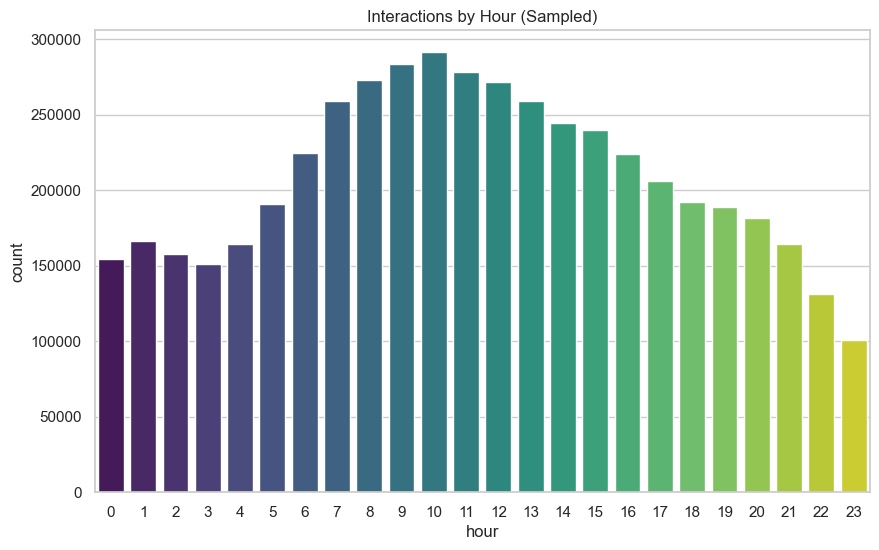

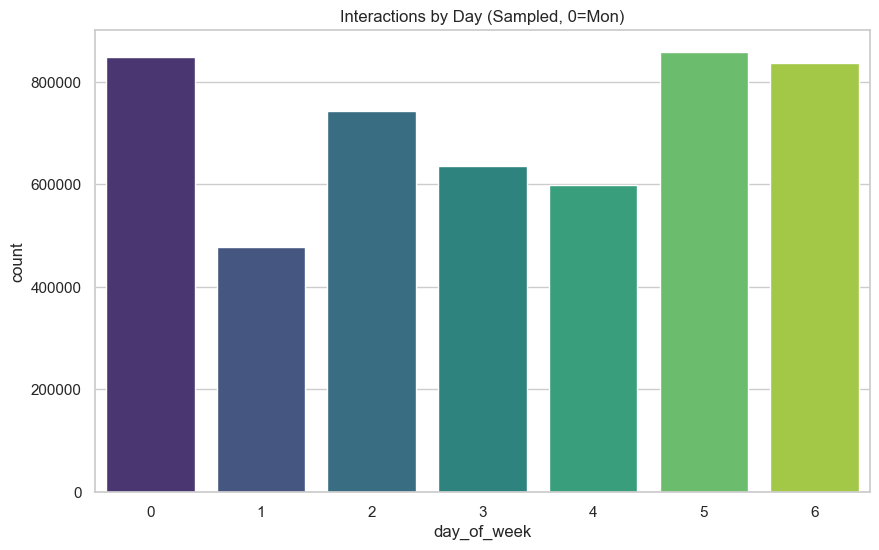

# Informations on interactions data test:
Shape: (4676570, 8)
Head:
    user_id  video_id  play_duration  video_duration                     time  \
0       14       148           4381            6067  2020-07-05 05:27:48.378   
1       14       183          11635            6100  2020-07-05 05:28:00.057   
2       14      3649          22422           10867  2020-07-05 05:29:09.479   
3       14      5262           4479            7908  2020-07-05 05:30:43.285   
4       14      8234           4602           11000  2020-07-05 05:35:43.459   

         date     timestamp  watch_ratio  
0  20200705.0  1.593898e+09     0.722103  
1  20200705.0  1.593898e+09     1.907377  
2  20200705.0  1.593898e+09     2.063311  
3  20200705.0  1.593898e+09     0.566388  
4  20200705.0  1.593899e+09     0.418364  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676570 entries, 0 to 4676569
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id   

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_2056\397582565.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_meta_df_cleaned['video_id'] = video_meta_df_cleaned['video_id_numeric'].astype(target_video_id_dtype)
C:\Users\Baptiste\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Baptiste\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Baptiste\AppData\Local\Programs\Python\Python38\lib\site

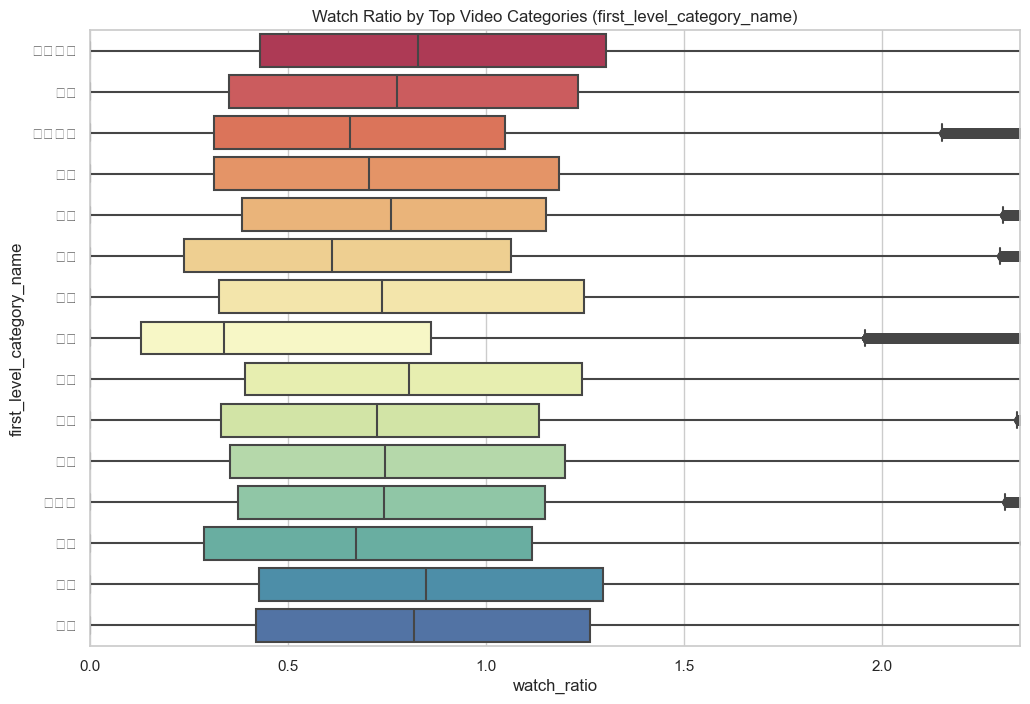

In [7]:
TARGET_COL = 'watch_ratio'

try:

    print("# Informations on interactions data :")
    print("Shape:", interactions_df.shape)
    print("Head:\n", interactions_df.head())
    print("\nInfo:")
    interactions_df.info(memory_usage='deep')
    print("\nDescribe:\n", interactions_df.describe(include='all'))
    print("\nMissing values:\n", interactions_df.isnull().sum())

    print(interactions_df[TARGET_COL].describe())

    sparsity, n_users, n_items, n_interactions = calculate_sparsity(interactions_df)
    print(f"\nTraining data overview: Users={n_users}, Videos={n_items}, Interactions={n_interactions}, Sparsity={sparsity*100:.2f}%")

    user_counts = interactions_df['user_id'].value_counts()
    print("User interaction counts describe:\n", user_counts.describe())

    item_counts = interactions_df['video_id'].value_counts()
    print("Video interaction counts describe:\n", item_counts.describe())

    interactions_df['datetime'] = pd.to_datetime(interactions_df['time'])
    interactions_df['hour'] = interactions_df['datetime'].dt.hour
    interactions_df['day_of_week'] = interactions_df['datetime'].dt.dayofweek
    plt.figure(figsize=(10,6)); sns.countplot(data=interactions_df, x='hour', palette='viridis'); plt.title('Interactions by Hour (Sampled)'); plt.show()
    plt.figure(figsize=(10,6)); sns.countplot(data=interactions_df, x='day_of_week', palette='viridis'); plt.title('Interactions by Day (Sampled, 0=Mon)'); plt.show()
except:
    print("ERROR performing analysis on interactions_df (file big_matrix.csv). Make sure data files are in the good place and make sure you ran Phase 1 correctly")



try:
    print("# Informations on interactions data test:")
    print("Shape:", interactions_df_test.shape)
    print("Head:\n", interactions_df_test.head())
    print("\nInfo:")
    interactions_df_test.info(memory_usage='deep')
    print("\nMissing values:\n", interactions_df_test.isnull().sum())

    if TARGET_COL in interactions_df_test.columns:
        print(f"{TARGET_COL} describe in small_matrix.csv:\n", interactions_df_test[TARGET_COL].describe())

    sparsity_test, n_users_test, n_items_test, n_interactions_test = calculate_sparsity(interactions_df_test)
    print(f"\nTest Data overview: Users={n_users_test}, Videos={n_items_test}, Interactions={n_interactions_test}")
except:
    print("ERROR performing analysis on interactions_df_test (file small_matrix.csv). Make sure data files are in the good place and make sure you ran Phase 1 correctly")


try:
    print("# Informations on video metadata:")
    print("Shape:", video_meta_df.shape)
    print("Head:\n", video_meta_df.head())
    print("\nMissing values:\n", video_meta_df.isnull().sum().sort_values(ascending=False).head())
    
    METADATA_CATEGORY_COL = 'first_level_category_name'
    if METADATA_CATEGORY_COL in video_meta_df.columns:
        print(f"\nTop 10 video categories from '{METADATA_CATEGORY_COL}':\n", video_meta_df[METADATA_CATEGORY_COL].value_counts().nlargest(10))
except:
    print("ERROR performing analysis on video_meta_df (file kuairec_caption_category.csv). Make sure data files are in the good place and make sure you ran Phase 1 correctly")


try:
    print("# Informations on user features:")
    print("Shape:", user_features_df.shape)
    print("Head:\n", user_features_df.head())
    print("\nMissing values:\n", user_features_df.isnull().sum().sort_values(ascending=False).head())
    if 'user_active_degree' in user_features_df.columns:
        print("\nUser Active Degree distribution:\n", user_features_df['user_active_degree'].value_counts(normalize=True).mul(100).round(1))
except:
    print("ERROR performing analysis on user_feature_df (file user_features.csv). Make sure data files are in the good place and make sure you ran Phase 1 correctly")



merged_df_eda = pd.DataFrame()

try:
    if interactions_df['video_id'].dtype != video_meta_df['video_id'].dtype:
        print("interaction_df and video_meta_df don't have the same type, we will do some type conversion")
        try:
            video_meta_df['video_id_numeric'] = pd.to_numeric(video_meta_df['video_id'], errors='coerce')
            
            original_non_null = video_meta_df['video_id'].notnull().sum()
            coerced_non_null = video_meta_df['video_id_numeric'].notnull().sum()
            num_coerced_to_nan = original_non_null - coerced_non_null
            
            video_meta_df_cleaned = video_meta_df.dropna(subset=['video_id_numeric'])
            
            target_video_id_dtype = interactions_df['video_id'].dtype
            video_meta_df_cleaned['video_id'] = video_meta_df_cleaned['video_id_numeric'].astype(target_video_id_dtype)
                        
            merged_df_eda = pd.merge(interactions_df, video_meta_df_cleaned.drop(columns=['video_id_numeric']), on='video_id', how='left')
            
        except:
            print("failed to do conversion, we will still continue but initial given data are probably not good")
            merged_df_eda = interactions_df.copy()
    else:
        merged_df_eda = pd.merge(interactions_df, video_meta_df, on='video_id', how='left')

    if not user_features_df.empty and not merged_df_eda.empty:
        if merged_df_eda['user_id'].dtype != user_features_df['user_id'].dtype:
            print("doing some conversion again")
            try:
                user_features_df['user_id_numeric'] = pd.to_numeric(user_features_df['user_id'], errors='coerce')
                
                original_non_null_user = user_features_df['user_id'].notnull().sum()
                coerced_non_null_user = user_features_df['user_id_numeric'].notnull().sum()
                num_coerced_to_nan_user = original_non_null_user - coerced_non_null_user

                user_features_df_cleaned = user_features_df.dropna(subset=['user_id_numeric'])
                target_user_id_dtype = merged_df_eda['user_id'].dtype
                user_features_df_cleaned['user_id'] = user_features_df_cleaned['user_id_numeric'].astype(target_user_id_dtype)
                
                merged_df_eda = pd.merge(merged_df_eda, user_features_df_cleaned.drop(columns=['user_id_numeric']), on='user_id', how='left')

            except:
                print("failed to do conversion, we will still continue but initial given data are probably not good")
        else:
            merged_df_eda = pd.merge(merged_df_eda, user_features_df, on='user_id', how='left')
    
    if not merged_df_eda.empty:
        if METADATA_CATEGORY_COL in merged_df_eda.columns and TARGET_COL in merged_df_eda.columns:
            plt.figure(figsize=(12,8))
            top_cats = merged_df_eda[METADATA_CATEGORY_COL].value_counts().nlargest(15).index
            sns.boxplot(data=merged_df_eda[merged_df_eda[METADATA_CATEGORY_COL].isin(top_cats)],
                        x=TARGET_COL, y=METADATA_CATEGORY_COL, orient='h', palette='Spectral')
            plt.title(f'Watch Ratio by Top Video Categories ({METADATA_CATEGORY_COL})')
            if merged_df_eda[TARGET_COL].nunique() > 1:
                plt.xlim(0, merged_df_eda[TARGET_COL].quantile(0.95))
            else:
                plt.xlim(0,3)
            plt.show()
        
        del merged_df_eda 
        gc.collect()

except:
    print("ERROR performing analysis on interactions_df and video_meta_df (files big_matrix.csv and kuairec_caption_category.csv). Make sure data files are in the good place and make sure you ran Phase 1 correctly")


This phase 2 showed that the datasets has high sparsity, skewed watch_ratio distributions (often >1.0). Temporal analysis showed daily and weekly interaction trends. Metadata for videos and users provide potentially usefull features like categories and activity levels. This phase shows the data richness

# Phase 3 : Feature Engineering and Data processing
## Type handling
Here we check if video_id and user_id columns has matching data type (which they don't), and we convert the type to merge

In [8]:
if interactions_df.empty:
    print("ERROR, interactions_df is empty, probability because big_matrix is wrong or not placed at the right place")
else:

    if interactions_df['video_id'].dtype != video_meta_df['video_id'].dtype:
        print("we are going to convert some types because its not consistent in interaction_df and video_meta_df")
        try:
            video_meta_df['video_id_numeric'] = pd.to_numeric(video_meta_df['video_id'], errors='coerce')
            num_coerced_nan_video = video_meta_df['video_id_numeric'].isnull().sum() - video_meta_df['video_id'].isnull().sum()
            video_meta_df.dropna(subset=['video_id_numeric'], inplace=True)
            video_meta_df['video_id'] = video_meta_df['video_id_numeric'].astype(interactions_df['video_id'].dtype)
            video_meta_df.drop(columns=['video_id_numeric'], inplace=True)
        except:
            print("Error when trying to convert types, initial given datas might be wrong")



    if interactions_df['user_id'].dtype != user_features_df['user_id'].dtype:
        print("converting some types")
        try:
            user_features_df['user_id_numeric'] = pd.to_numeric(user_features_df['user_id'], errors='coerce')
            num_coerced_nan_user = user_features_df['user_id_numeric'].isnull().sum() - user_features_df['user_id'].isnull().sum()
            user_features_df.dropna(subset=['user_id_numeric'], inplace=True)
            user_features_df['user_id'] = user_features_df['user_id_numeric'].astype(interactions_df['user_id'].dtype)
            user_features_df.drop(columns=['user_id_numeric'], inplace=True)
        except:
            print("Error when trying to convert types, initial given datas might be wrong")

    
    gc.collect()

print("type Handle done succesfully")

we are going to convert some types because its not consistent in interaction_df and video_meta_df
type Handle done succesfully


## Merging
Here we merge traning data with metadata

In [9]:
processed_df = interactions_df.copy() 

try:
    processed_df = pd.merge(processed_df, video_meta_df, on='video_id', how='left')
except:
    print("ERROR when merging, wrong types in datas")
          
try:
    processed_df = pd.merge(processed_df, user_features_df, on='user_id', how='left')
except:
    print("ERROR when merging, wrong types in datas")

     
gc.collect()

print("merging done !")

merging done !


## Reduce memory usage
Here we reduce memory usage by converting numeric columns from float64/int64 to float32/int32

In [10]:
for col in processed_df.columns:
    if processed_df[col].dtype == 'float64':
        processed_df[col] = pd.to_numeric(processed_df[col], downcast='float')
    elif processed_df[col].dtype == 'int64':
        processed_df[col] = pd.to_numeric(processed_df[col], downcast='integer')
gc.collect()

print("recued memory usage !")

recued memory usage !


## Handling missing values
Here we fill missing values with 0s or 'Unknown'

In [11]:
if TARGET_COL in processed_df.columns and processed_df[TARGET_COL].isnull().any():
    fill_val = processed_df[TARGET_COL].median()
    processed_df[TARGET_COL].fillna(fill_val, inplace=True)

cat_meta_cols_to_fill = [METADATA_CATEGORY_COL, 'second_level_category_name', 'third_level_category_name']
for col in cat_meta_cols_to_fill:
    if col in processed_df.columns and processed_df[col].isnull().any():
        processed_df[col].fillna('Unknown', inplace=True)
    

onehot_cols = [f'onehot_feat{i}' for i in range(18)]
for col in onehot_cols:
    if col in processed_df.columns and processed_df[col].isnull().any():
        processed_df[col].fillna(0, inplace=True)

print("missing values handling done !")

missing values handling done !


## Data cleaning
Here we remove duplicate rows, we filter out invalid video durations and calculate "watch_ratio" (TARGET_COL)

In [12]:
initial_rows = len(processed_df)
processed_df.drop_duplicates(subset=['user_id', 'video_id', 'timestamp'], keep='first', inplace=True)

if 'video_duration' in processed_df.columns:
    invalid_duration = processed_df['video_duration'] <= 0
    if invalid_duration.any():
        processed_df = processed_df[~invalid_duration].copy()
        processed_df[TARGET_COL] = processed_df['play_duration'] / processed_df['video_duration']
        processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        if processed_df[TARGET_COL].isnull().any():
             processed_df[TARGET_COL].fillna(processed_df[TARGET_COL].median(), inplace=True)

print("data cleaning done !")

data cleaning done !


## Feature Engineering
Here we create new features and build the processed_df dataset

In [13]:
if 'datetime' in processed_df.columns:
    processed_df['is_weekend'] = processed_df['datetime'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
elif 'day_of_week' in processed_df.columns:
    processed_df['is_weekend'] = processed_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

cols_for_modeling_subset = [
    'user_id', 'video_id', TARGET_COL, 'hour', 'day_of_week', 'is_weekend',
    METADATA_CATEGORY_COL
]
simple_user_features = ['user_active_degree']
for f in simple_user_features:
    if f in processed_df.columns:
        cols_for_modeling_subset.append(f)
    
if METADATA_CATEGORY_COL not in processed_df.columns and 'first_level_category_name' in processed_df.columns:
    METADATA_CATEGORY_COL = 'first_level_category_name'
    if METADATA_CATEGORY_COL not in cols_for_modeling_subset:
         cols_for_modeling_subset.append(METADATA_CATEGORY_COL)



cols_for_modeling_subset = [col for col in cols_for_modeling_subset if col in processed_df.columns]
    
if cols_for_modeling_subset:
    processed_train_df = processed_df[cols_for_modeling_subset].copy()
else:
    processed_train_df = pd.DataFrame()

del processed_df
gc.collect()

print("Phase 3 done !")


Phase 3 done !


# Phase 4 : Splitting the datas And Feature Engineering
## Initialisation and data splitting

In [14]:
TARGET_COL = 'watch_ratio'
METADATA_CATEGORY_COL = 'first_level_category_name'
USER_ACTIVE_DEGREE_COL = 'user_active_degree'


train_df = pd.DataFrame()
val_df = pd.DataFrame()
val_df_for_ranking_metrics = pd.DataFrame()
X_train_final = None
y_train_final = None
X_val_final = None
y_val_final = None
all_feature_names = []
train_set_medians = {}


train_df, val_df = train_test_split(processed_train_df, test_size=0.2, random_state=42)
val_df_for_ranking_metrics = val_df[['user_id', 'video_id', TARGET_COL]].copy()

print("done init and splitting")

done init and splitting


## Engineering user features

In [15]:
user_stats_train = train_df.groupby('user_id').agg(
    user_interaction_count=('video_id', 'count'),
    user_avg_watch_ratio=(TARGET_COL, 'mean'),
).reset_index()


if train_df['user_id'].nunique() > 0:
    global_user_interaction_count = train_df['video_id'].count() / train_df['user_id'].nunique()
else:
    global_user_interaction_count = 0
global_user_avg_watch_ratio = train_df[TARGET_COL].mean()

train_df = train_df.merge(user_stats_train, on='user_id', how='left')

val_df = val_df.merge(user_stats_train, on='user_id', how='left')
val_df['user_interaction_count'].fillna(global_user_interaction_count, inplace=True)
val_df['user_avg_watch_ratio'].fillna(global_user_avg_watch_ratio, inplace=True)
gc.collect()

print("done user feature eng")

done user feature eng


## Engineering video features

In [16]:
video_stats_train = train_df.groupby('video_id').agg(
    video_interaction_count=('user_id', 'count'),
    video_avg_watch_ratio=(TARGET_COL, 'mean'),
    video_distinct_users_watched=('user_id', 'nunique')
).reset_index()

if train_df['video_id'].nunique() > 0:
    global_video_interaction_count = train_df['user_id'].count() / train_df['video_id'].nunique()
    global_video_distinct_users = train_df.groupby('video_id')['user_id'].nunique().mean()
else:
    global_video_interaction_count = 0
    global_video_distinct_users = 0
global_video_avg_watch_ratio = train_df[TARGET_COL].mean()


train_df = train_df.merge(video_stats_train, on='video_id', how='left')

val_df = val_df.merge(video_stats_train, on='video_id', how='left')
val_df['video_interaction_count'].fillna(global_video_interaction_count, inplace=True)
val_df['video_avg_watch_ratio'].fillna(global_video_avg_watch_ratio, inplace=True)
val_df['video_distinct_users_watched'].fillna(global_video_distinct_users, inplace=True)
gc.collect()

print("done video eng feature")

done video eng feature


## One-Hot Encoding
Here we one-hot encodes columns like time features and category labels in train_df and val_df, we convert them into a machine learning friendly sparse format.

In [17]:
categorical_cols_to_encode = []
if 'hour' in train_df.columns: categorical_cols_to_encode.append('hour')
if 'day_of_week' in train_df.columns: categorical_cols_to_encode.append('day_of_week')
if 'is_weekend' in train_df.columns: categorical_cols_to_encode.append('is_weekend')
if METADATA_CATEGORY_COL in train_df.columns: categorical_cols_to_encode.append(METADATA_CATEGORY_COL)
if USER_ACTIVE_DEGREE_COL in train_df.columns: categorical_cols_to_encode.append(USER_ACTIVE_DEGREE_COL)
    
categorical_cols_to_encode = [col for col in categorical_cols_to_encode if col in train_df.columns]

ohe_feature_names = []
train_ohe_sparse = None
val_ohe_sparse = None

for col in categorical_cols_to_encode:
    train_df[col].fillna('Unknown', inplace=True)
    if not val_df.empty and col in val_df.columns:
        val_df[col].fillna('Unknown', inplace=True)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
ohe.fit(train_df[categorical_cols_to_encode].astype(str))
        
train_ohe_sparse = ohe.transform(train_df[categorical_cols_to_encode].astype(str))
ohe_feature_names = ohe.get_feature_names_out(categorical_cols_to_encode).tolist()

val_ohe_sparse = ohe.transform(val_df[categorical_cols_to_encode].astype(str))
        
train_df.drop(columns=categorical_cols_to_encode, inplace=True, errors='ignore')
if not val_df.empty:
    val_df.drop(columns=categorical_cols_to_encode, inplace=True, errors='ignore')

gc.collect()

print("done one-hot encoding")

done one-hot encoding


## Using TF-IDF for Text Features
Here we extracts TF-IDF features from text columns like 'caption' and 'topic_tag', we turn them into numerical sparse matrices

In [18]:
text_feature_cols_info = []
if 'caption' in video_meta_df.columns:
    text_feature_cols_info.append({'name': 'caption', 'prefix': 'cap_tfidf_', 'max_features': 50})
if 'topic_tag' in video_meta_df.columns:
    text_feature_cols_info.append({'name': 'topic_tag', 'prefix': 'tag_tfidf_', 'max_features': 25})

tfidf_vectorizers = {}
train_tfidf_sparse_matrices = []
val_tfidf_sparse_matrices = []
tfidf_feature_names_list = []

if text_feature_cols_info:
    text_cols_to_merge = list(set([info['name'] for info in text_feature_cols_info]))
        
    if text_cols_to_merge and not video_meta_df.empty:
        video_meta_df_for_merge = video_meta_df.copy()
        if video_meta_df_for_merge['video_id'].dtype != train_df['video_id'].dtype:
             video_meta_df_for_merge['video_id'] = pd.to_numeric(video_meta_df_for_merge['video_id'], errors='coerce')
             video_meta_df_for_merge.dropna(subset=['video_id'], inplace=True)
             video_meta_df_for_merge['video_id'] = video_meta_df_for_merge['video_id'].astype(train_df['video_id'].dtype)

        train_df = pd.merge(train_df, video_meta_df_for_merge[['video_id'] + text_cols_to_merge], on='video_id', how='left')
        if not val_df.empty:
            val_df = pd.merge(val_df, video_meta_df_for_merge[['video_id'] + text_cols_to_merge], on='video_id', how='left')
        del video_meta_df_for_merge

    for col_info in text_feature_cols_info:
        text_col = col_info['name']
        prefix = col_info['prefix']
        max_f = col_info['max_features']
            
        if text_col in train_df.columns:
            train_df[text_col].fillna("", inplace=True)
            train_df[text_col] = train_df[text_col].apply(clean_text)
            if not val_df.empty and text_col in val_df.columns:
                val_df[text_col].fillna("", inplace=True)
                val_df[text_col] = val_df[text_col].apply(clean_text)

            vectorizer = TfidfVectorizer(max_features=max_f, stop_words='english', ngram_range=(1,1))
            vectorizer.fit(train_df[text_col])
            tfidf_vectorizers[text_col] = vectorizer

            current_tfidf_feature_names = [prefix + f for f in vectorizer.get_feature_names_out()]
            tfidf_feature_names_list.extend(current_tfidf_feature_names)

            train_tfidf_sparse = vectorizer.transform(train_df[text_col])
            train_tfidf_sparse_matrices.append(train_tfidf_sparse)
                
            if not val_df.empty and text_col in val_df.columns:
                val_tfidf_sparse = vectorizer.transform(val_df[text_col])
                val_tfidf_sparse_matrices.append(val_tfidf_sparse)
                
            train_df.drop(columns=[text_col], inplace=True, errors='ignore')
            if text_col in val_df.columns:
                val_df.drop(columns=[text_col], inplace=True, errors='ignore')

            gc.collect()

print("done tf-idf for text feature")

done tf-idf for text feature


## Scale for Numerical features

In [19]:
numerical_cols_to_scale = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_cols_to_scale = [col for col in numerical_cols_to_scale if col not in [TARGET_COL, 'user_id', 'video_id']]
    
numerical_scaler = None 
train_set_medians = {} 

numerical_scaler = StandardScaler()
        
for col in numerical_cols_to_scale:
    if train_df[col].isnull().any():
        median_val = train_df[col].median() 
        train_set_medians[col] = median_val
                
        train_df[col].fillna(median_val, inplace=True)
    else:
        train_set_medians[col] = train_df[col].median()


    if not val_df.empty and col in val_df.columns:
        val_df[col].fillna(train_set_medians[col], inplace=True) 



numerical_scaler.fit(train_df[numerical_cols_to_scale])
        
train_df[numerical_cols_to_scale] = numerical_scaler.transform(train_df[numerical_cols_to_scale])
        
cols_to_scale_in_val = [col for col in numerical_cols_to_scale if col in val_df.columns]
if cols_to_scale_in_val:
     val_df[cols_to_scale_in_val] = numerical_scaler.transform(val_df[cols_to_scale_in_val])

gc.collect()

print("scaling done")

scaling done


## Creating the Sparse Matrix And doing some Cleaning
Here we create the final sparse feature matrices (X_train_final and X_val_final) by using the tf-idf, one-hot encoding and numeric features

In [20]:
dense_cols_for_csr = train_df.select_dtypes(include=np.number).columns.tolist()
dense_cols_for_csr = [col for col in dense_cols_for_csr if col not in [TARGET_COL, 'user_id', 'video_id']]
    
for col in dense_cols_for_csr:
    if train_df[col].isnull().any():
        train_df[col].fillna(0, inplace=True)
    if not val_df.empty and col in val_df.columns and val_df[col].isnull().any():
        val_df[col].fillna(0, inplace=True)

if dense_cols_for_csr:
    train_other_features_sparse = csr_matrix(train_df[dense_cols_for_csr].values.astype(np.float32))
    all_feature_names.extend(dense_cols_for_csr) 
else:
    train_other_features_sparse = csr_matrix((len(train_df), 0))


train_sparse_parts_to_stack = [train_other_features_sparse]
if train_ohe_sparse is not None: 
    train_sparse_parts_to_stack.append(train_ohe_sparse)
    all_feature_names.extend(ohe_feature_names)
if train_tfidf_sparse_matrices: 
    train_sparse_parts_to_stack.extend(train_tfidf_sparse_matrices)
    all_feature_names.extend(tfidf_feature_names_list)

X_train_final = hstack(train_sparse_parts_to_stack, format='csr')
y_train_final = train_df[TARGET_COL].values


if dense_cols_for_csr:
    val_other_features_sparse = csr_matrix(val_df[dense_cols_for_csr].values.astype(np.float32))
else:
    val_other_features_sparse = csr_matrix((len(val_df), 0))
            
val_sparse_parts_to_stack = [val_other_features_sparse]
if val_ohe_sparse is not None:
    val_sparse_parts_to_stack.append(val_ohe_sparse)
if val_tfidf_sparse_matrices:
    val_sparse_parts_to_stack.extend(val_tfidf_sparse_matrices) 
            
X_val_final = hstack(val_sparse_parts_to_stack, format='csr')
y_val_final = val_df[TARGET_COL].values
    

if 'train_ohe_sparse' in locals() and train_ohe_sparse is not None: 
    del train_ohe_sparse
if 'train_tfidf_sparse_matrices' in locals() and train_tfidf_sparse_matrices: 
    del train_tfidf_sparse_matrices
if not val_df.empty:
    if 'val_ohe_sparse' in locals() and val_ohe_sparse is not None: 
        del val_ohe_sparse
    if 'val_tfidf_sparse_matrices' in locals() and val_tfidf_sparse_matrices: 
        del val_tfidf_sparse_matrices
gc.collect()

print("sparce matrix and cleaning done")

sparce matrix and cleaning done


# Phase 5 : Baseline Model
We create and calculate a baseline model’s RMSE and MAE by predicting each video's average watch ratio from the training set. If the video isn't seen in training, it uses the global average.

In [21]:
baseline_metrics = {}

conti = False

try:
    (train_df.shape, val_df.shape, y_val_final.shape)
    conti = True
except:
    print("Dataframes are not found, its because you haven't run the code cells before, start over.")

if conti:

    item_avg_watch_ratio_map = train_df.groupby('video_id')[TARGET_COL].mean().to_dict()
    
    global_avg_watch_ratio_val = train_df[TARGET_COL].mean()
    print(f"Global average {TARGET_COL}: {global_avg_watch_ratio_val}")

    baseline_predictions = val_df['video_id'].map(item_avg_watch_ratio_map).fillna(global_avg_watch_ratio_val)
    
    if len(baseline_predictions) == len(y_val_final):
        baseline_rmse = np.sqrt(mean_squared_error(y_val_final, baseline_predictions))
        baseline_mae = mean_absolute_error(y_val_final, baseline_predictions)
        
        print(f"Baseline RMSE on validation set: {baseline_rmse}")
        print(f"Baseline MAE on validation set: {baseline_mae}")
        
        baseline_metrics['item_avg_rmse'] = baseline_rmse
        baseline_metrics['item_avg_mae'] = baseline_mae
    else:
        print("Error: len is not the same.")

gc.collect()

Global average watch_ratio: 0.9505503177642822
Baseline RMSE on validation set: 1.692087968431179
Baseline MAE on validation set: 0.5427551189329164


0

# Phase 6 : Neural Network Model

In [22]:
model_filename_nn = os.path.join(MODELS_DIR, "nn_recommender_model.h5")

skip_nn_training = False 

if os.path.exists(model_filename_nn):
    skip_nn_training = True


nn_model = None

if skip_nn_training:
    print("Model nn_recommender_model.h5 already exists in /models, skipping this Neural Network model creation and training step...going to next step : evaluation")
elif X_train_final is not None and y_train_final is not None and \
   X_val_final is not None and y_val_final is not None:

    input_shape = (X_train_final.shape[1],)

    input_features = Input(shape=input_shape, sparse=True, name='sparse_features')

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense_1')(input_features)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='dense_2')(x)
    x = Dropout(0.3, name='dropout_2')(x)

    output_layer = Dense(1, activation='linear', name='output_watch_ratio')(x)

    nn_model = Model(inputs=input_features, outputs=output_layer, name='NN_Recommender')

    nn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[RootMeanSquaredError(name='rmse'), 'mae']
    )

    nn_model.summary()

    X_train_final.sort_indices()
    X_val_final.sort_indices()

    print("Lets go training the model")
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_rmse',
        patience=10,         
        restore_best_weights=True,
        verbose=1
    )


    history = nn_model.fit(
        X_train_final,
        y_train_final,
        epochs=50,
        batch_size=256,
        validation_data=(X_val_final, y_val_final),
        callbacks=[early_stopping],
        verbose=1 
    )

    print("Neural Network model training complete.")

    if history:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('NN Model Loss (MSE)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['rmse'], label='Train RMSE')
        plt.plot(history.history['val_rmse'], label='Val RMSE')
        plt.title('NN Model RMSE')
        plt.xlabel('Epoch'); plt.ylabel('RMSE')
        plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show()

    nn_model.save(model_filename_nn)
    print(f"Neural Network model saved to {model_filename_nn}")

else:
    print("Missing dataframes, rerun the code from start will probably fix")

gc.collect()

Model nn_recommender_model.h5 already exists in /models, skipping this Neural Network model creation and training step...going to next step : evaluation


0

# Phase 7 : NN Model evaluation
## Init and prediction
Here we laod the model, we makes predictions on a validation set and print performance metrics

In [23]:
MODELS_DIR = os.path.join(".", "models")


K_RANK = 10
RELEVANCE_THRESHOLD = 1.0

final_model = None
y_pred_val_final_nn = None

final_model_path = os.path.join(MODELS_DIR, "nn_recommender_model.h5") 

final_model = None

if os.path.exists(final_model_path):
    final_model = keras.models.load_model(final_model_path)
    final_model.summary(line_length=120) 
else:
    try:
        final_model = nn_model
        final_model.summary(line_length=120)
    except:
        final_model = None

if final_model == None:
    print(f"ERROR: Saved model not found at {final_model_path}. Make sure you ran Phase 6 correctly")



if final_model:
    
    if X_val_final.shape[1] != final_model.input_shape[1]:
        print("ERROR, shape doesn't match. Datas doesn't match the model. Datas might has changed")
    else:
        if hasattr(X_val_final, 'sort_indices'): 
            X_val_final.sort_indices()

        y_pred_val_final_nn = final_model.predict(X_val_final)
        
        final_nn_rmse = np.sqrt(mean_squared_error(y_val_final, y_pred_val_final_nn))
        final_nn_mae = mean_absolute_error(y_val_final, y_pred_val_final_nn)
        print(f"NN RMSE on Validation: {final_nn_rmse}")
        print(f"NN MAE on Validation: {final_nn_mae}")

        baseline_metrics['final_nn_157f_rmse'] = final_nn_rmse
        baseline_metrics['final_nn_157f_mae'] = final_nn_mae

print("done init and prediction")

Model: "NN_Recommender"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 sparse_features (InputLayer)                         [(None, 157)]                                   0                 
                                                                                                                        
 dense_1 (Dense)                                      (None, 128)                                     20224             
                                                                                                                        
 dropout_1 (Dropout)                                  (None, 128)                                     0                 
                                                                                                                        
 dense_2

## Generating Top-N Ranked Lists for Validation Users

In [24]:
user_recommendations_val = {} 

temp_val_df_ranking = val_df_for_ranking_metrics.copy()
temp_val_df_ranking['predicted_score'] = y_pred_val_final_nn.flatten()

for user_id, group in temp_val_df_ranking.groupby('user_id'):
    sorted_group = group.sort_values('predicted_score', ascending=False)
            
    ranked_videos_tuples = []
    for _, row in sorted_group.iterrows():
        ranked_videos_tuples.append( (row['video_id'], row['predicted_score'], row[TARGET_COL]) )
    user_recommendations_val[user_id] = ranked_videos_tuples
            
del temp_val_df_ranking
gc.collect()

print("Ranked lists done")

Ranked lists done


## Calculating Ranking Metrics on Validation Set

In [25]:
all_precisions_at_k = []
all_recalls_at_k = []
all_ndcgs_at_k = []

for user_id, ranked_list_tuples in user_recommendations_val.items():
    user_true_interactions_df = val_df_for_ranking_metrics[val_df_for_ranking_metrics['user_id'] == user_id]
            
    all_relevant_for_user_set = set(
        user_true_interactions_df[user_true_interactions_df[TARGET_COL] >= RELEVANCE_THRESHOLD]['video_id']
    )
        
    all_precisions_at_k.append(precision_at_k(ranked_list_tuples, K_RANK, RELEVANCE_THRESHOLD))
    all_recalls_at_k.append(recall_at_k(ranked_list_tuples, all_relevant_for_user_set, K_RANK))
    all_ndcgs_at_k.append(ndcg_at_k(ranked_list_tuples, K_RANK))
        
avg_precision_at_k = np.mean(all_precisions_at_k) if all_precisions_at_k else 0.0
avg_recall_at_k = np.mean(all_recalls_at_k) if all_recalls_at_k else 0.0
avg_ndcg_at_k = np.mean(all_ndcgs_at_k) if all_ndcgs_at_k else 0.0

print(f"\nAverage Precision@{K_RANK} (relevance threshold >= {RELEVANCE_THRESHOLD}): {avg_precision_at_k}")
print(f"Average Recall@{K_RANK} (relevance threshold >= {RELEVANCE_THRESHOLD}): {avg_recall_at_k}")
print(f"Average NDCG@{K_RANK} (using relevance threshold >= {RELEVANCE_THRESHOLD} for gain): {avg_ndcg_at_k}")

baseline_metrics[f'final_nn_157f_p@{K_RANK}'] = avg_precision_at_k
baseline_metrics[f'final_nn_157f_r@{K_RANK}'] = avg_recall_at_k
baseline_metrics[f'final_nn_157f_ndcg@{K_RANK}'] = avg_ndcg_at_k

gc.collect()

print("\nSummary of Metrics (baseline and final NN):")
for model_name, metric_val in baseline_metrics.items():
    print(f"  {model_name}: {metric_val:.4f}")


print("metrics done")


Average Precision@10 (relevance threshold >= 1.0): 0.7097154753643303
Average Recall@10 (relevance threshold >= 1.0): 0.1141767506442521
Average NDCG@10 (using relevance threshold >= 1.0 for gain): 0.47388851258182196

Summary of Metrics (baseline and final NN):
  item_avg_rmse: 1.6921
  item_avg_mae: 0.5428
  final_nn_157f_rmse: 1.6691
  final_nn_157f_mae: 0.5417
  final_nn_157f_p@10: 0.7097
  final_nn_157f_r@10: 0.1142
  final_nn_157f_ndcg@10: 0.4739
metrics done


# Phase 8 : Data Preparation and Prediction for Submission
We are going to process the small_matrix.csv datas the same way we did before
## Loading
Here we load Test Interactions (small_matrix.csv)

In [26]:
test_df_processed = pd.DataFrame()
X_test_submission_final = None
predicted_scores_test = None
submission_user_ids = None
submission_video_ids = None


try:
    test_df_processed = pd.read_csv(PATH_PROJECT_INTERACTIONS_TEST)
except:
    prinrt("ERROR cannot load the interaction test")


print("loading done")

loading done


## Preprocessing and feature Engineering to test data
Here we make sure that test_df_processed is merged, cleaned, type-cast, deduplicated, feature-engineered, and transformed (OHE, TF-IDF, scaling) so it can be fed into the trained model.

These are basically the same steps we did in phase 3/4

In [27]:
original_test_rows = len(test_df_processed)

if test_df_processed['video_id'].dtype != video_meta_df['video_id'].dtype:
    print("Changing types")
    try:
        video_meta_df_copy = video_meta_df.copy()
        video_meta_df_copy['video_id_numeric'] = pd.to_numeric(video_meta_df_copy['video_id'], errors='coerce')
        video_meta_df_copy.dropna(subset=['video_id_numeric'], inplace=True)
        video_meta_df_copy['video_id'] = video_meta_df_copy['video_id_numeric'].astype(test_df_processed['video_id'].dtype)
        test_df_processed = pd.merge(test_df_processed, video_meta_df_copy.drop(columns=['video_id_numeric']), on='video_id', how='left')
        del video_meta_df_copy
    except:
        print("Error when handling type")
else:
    test_df_processed = pd.merge(test_df_processed, video_meta_df, on='video_id', how='left')

if test_df_processed['user_id'].dtype != user_features_df['user_id'].dtype:
    print("Changing types")
    try:
        user_features_df_copy = user_features_df.copy()
        user_features_df_copy['user_id_numeric'] = pd.to_numeric(user_features_df_copy['user_id'], errors='coerce')
        user_features_df_copy.dropna(subset=['user_id_numeric'], inplace=True)
        user_features_df_copy['user_id'] = user_features_df_copy['user_id_numeric'].astype(test_df_processed['user_id'].dtype)
        test_df_processed = pd.merge(test_df_processed, user_features_df_copy.drop(columns=['user_id_numeric']), on='user_id', how='left')
        del user_features_df_copy
    except:
        print("Error when handling type")
else:
    test_df_processed = pd.merge(test_df_processed, user_features_df, on='user_id', how='left')
gc.collect()

for col in test_df_processed.columns:
    if test_df_processed[col].dtype == 'float64':
        test_df_processed[col] = pd.to_numeric(test_df_processed[col], downcast='float')
    elif test_df_processed[col].dtype == 'int64':
        test_df_processed[col] = pd.to_numeric(test_df_processed[col], downcast='integer')
gc.collect()
    
initial_rows_before_dedup = len(test_df_processed)
test_df_processed.drop_duplicates(subset=['user_id', 'video_id', 'timestamp'], keep='first', inplace=True)

if 'video_duration' in test_df_processed.columns:
    invalid_duration_test = test_df_processed['video_duration'] <= 0
    if invalid_duration_test.any():
        test_df_processed = test_df_processed[~invalid_duration_test].copy()
        if TARGET_COL in test_df_processed.columns and 'play_duration' in test_df_processed.columns:
             test_df_processed[TARGET_COL] = test_df_processed['play_duration'] / test_df_processed['video_duration']
             test_df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
             try:
                 test_df_processed[TARGET_COL].fillna(global_avg_watch_ratio, inplace=True)
             except:
                 test_df_processed[TARGET_COL].fillna(0, inplace=True)

submission_user_ids = test_df_processed['user_id'].copy()
submission_video_ids = test_df_processed['video_id'].copy()


for col in [METADATA_CATEGORY_COL, 'second_level_category_name', 'third_level_category_name', USER_ACTIVE_DEGREE_COL]:
    if col in test_df_processed.columns:
        test_df_processed[col].fillna('Unknown', inplace=True)

onehot_cols_test = [f'onehot_feat{i}' for i in range(18)]
for col in onehot_cols_test:
    if col in test_df_processed.columns:
        test_df_processed[col].fillna(0, inplace=True)

if 'time' in test_df_processed.columns:
    test_df_processed['datetime'] = pd.to_datetime(test_df_processed['time'], errors='coerce')
    test_df_processed['hour'] = test_df_processed['datetime'].dt.hour.fillna(test_df_processed['datetime'].dt.hour.median()).astype(int)
    test_df_processed['day_of_week'] = test_df_processed['datetime'].dt.dayofweek.fillna(test_df_processed['datetime'].dt.dayofweek.median()).astype(int)
    test_df_processed['is_weekend'] = test_df_processed['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

test_df_processed = test_df_processed.merge(user_stats_train, on='user_id', how='left')
test_df_processed['user_interaction_count'].fillna(global_user_interaction_count, inplace=True)
test_df_processed['user_avg_watch_ratio'].fillna(global_user_avg_watch_ratio, inplace=True)
    
test_df_processed = test_df_processed.merge(video_stats_train, on='video_id', how='left')
test_df_processed['video_interaction_count'].fillna(global_video_interaction_count, inplace=True)
test_df_processed['video_avg_watch_ratio'].fillna(global_video_avg_watch_ratio, inplace=True)
test_df_processed['video_distinct_users_watched'].fillna(global_video_distinct_users, inplace=True)
gc.collect()

test_ohe_sparse = None
for col in categorical_cols_to_encode:
    if col not in test_df_processed.columns:
        test_df_processed[col] = 'Unknown'
    else:
        test_df_processed[col].fillna('Unknown', inplace=True)
    
test_ohe_sparse = ohe.transform(test_df_processed[categorical_cols_to_encode].astype(str))

test_tfidf_sparse_matrices = []
for col_info in text_feature_cols_info:
    text_col = col_info['name']
    if text_col in test_df_processed.columns:
        test_df_processed[text_col].fillna("", inplace=True)
        test_df_processed[text_col] = test_df_processed[text_col].apply(clean_text)
        vectorizer = tfidf_vectorizers.get(text_col)
        if vectorizer:
            test_tfidf_sparse = vectorizer.transform(test_df_processed[text_col])
            test_tfidf_sparse_matrices.append(test_tfidf_sparse)
        else:
            test_tfidf_sparse_matrices.append(csr_matrix((len(test_df_processed), col_info.get('max_features', 100))))
    else:
        test_tfidf_sparse_matrices.append(csr_matrix((len(test_df_processed), col_info.get('max_features', 100))))

gc.collect()


for col in numerical_cols_to_scale:
    if col not in test_df_processed.columns:
        test_df_processed[col] = 0.0
    else:
        median_val = train_set_medians.get(col, 0.0)

        test_df_processed[col].fillna(median_val, inplace=True)
    
cols_to_scale_in_test = [col for col in numerical_cols_to_scale if col in test_df_processed.columns]
if cols_to_scale_in_test:
    test_df_processed[cols_to_scale_in_test] = numerical_scaler.transform(test_df_processed[cols_to_scale_in_test])
  

current_dense_features_for_test = []
for col in dense_cols_for_csr:
    current_dense_features_for_test.append(test_df_processed[col])
    
if current_dense_features_for_test:
    test_other_features_sparse = csr_matrix(pd.concat(current_dense_features_for_test, axis=1).values.astype(np.float32))
else:
    test_other_features_sparse = csr_matrix((len(test_df_processed), 0))


test_sparse_parts_to_stack = [test_other_features_sparse]
if test_ohe_sparse is not None:
    test_sparse_parts_to_stack.append(test_ohe_sparse)
if test_tfidf_sparse_matrices:
    test_sparse_parts_to_stack.extend(test_tfidf_sparse_matrices)
        
X_test_submission_final = hstack(test_sparse_parts_to_stack, format='csr')
gc.collect()


print("processing and feature engeneering done")

processing and feature engeneering done


# Loading Trained NN Model

In [28]:
final_model_for_submission = None
final_model_path_submission = os.path.join(MODELS_DIR, "nn_recommender_model.h5")
final_model_for_submission = keras.models.load_model(final_model_path_submission)

print(f"Model loaded from: {final_model_path_submission}")

Model loaded from: .\models\nn_recommender_model.h5


# Generating Predictions

In [29]:


X_test_submission_final.sort_indices()
predicted_scores_test = final_model_for_submission.predict(X_test_submission_final)
        
gc.collect()


print("Predictions done, let's go for phase 9")

146143/146143 [==============================] - 125s 851us/step
Predictions done, let's go for phase 9


# Phase 9 : Create Submission File

In [30]:
scores_flat = predicted_scores_test.flatten() if hasattr(predicted_scores_test, 'flatten') else predicted_scores_test

submission_df = pd.DataFrame({
    'user_id': submission_user_ids,
    'video_id': submission_video_ids, 
    'score': scores_flat           
})


try:
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR, exist_ok=True)

    submission_df.to_csv(PATH_SUBMISSION_OUTPUT, index=False)

    print(f"Submission file successfully saved as {PATH_SUBMISSION_OUTPUT}")
except:
    print("ERROR, could not save subsmission file. It works fine on my pc")
            

gc.collect()

Submission file successfully saved as .\outputs\submission.csv


0